#Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.18.0'

#Dataset pre-processamento

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [5]:
X_train = (X_train - 127.5) / 127.5 #redim -1 e 1
type(X_train)

numpy.ndarray

Wgan vai utilizar apenas o X_train, não as classes em y_train, importamos ela pois viria em conjunto. Mas em outros tipos de treinamento, incluiria (X_train, y_train) abaixo.

In [6]:
buffer_size = y_train.shape[0]
batch_size = 512 # pode usar 256 ou 128 para uso da gpu (potencias de 2 são melhor paralelizadas)

X_train = tf.data.Dataset.from_tensor_slices(X_train). shuffle(buffer_size).batch(batch_size)
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

# Gerador e Discriminador Networks

são utilizadas as mesmas networks da DCGAN, a diferença da WGAN está no tratamento da loss.

In [7]:
def cria_gerador():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) #(100,) transforma em tupla
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7, 7, 256)))

  #7x7x128 (filters, kernel_size)
  network.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  #14x14x64
  network.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  #28x28x1
  network.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

  network.summary()
  return network

In [8]:
def cria_discriminador():
  network = tf.keras.Sequential()

  #recebe uma 28x28x1 e transforma em 14x14x64
  network.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  #7x7x128
  network.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # transforma em um vetor de 7*7*128, cada um será um neurônio ligado a um único neuronio
  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network

Criando e testando o gerador

In [9]:
gerador = cria_gerador()
gerador.inputs

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

[<KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor>]

(1, 28, 28, 1)


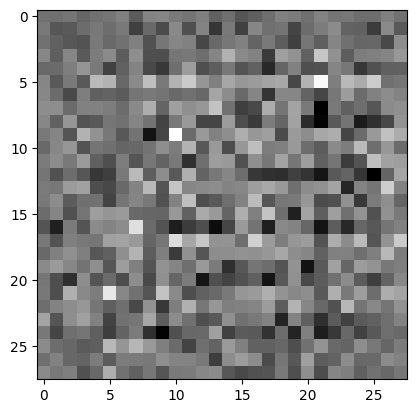

In [10]:
img = gerador(tf.random.normal([1, 100]), training=False) #envia um vetor de 100 itens e gera uma img
print(img.shape)
plt.imshow(img[0, :, :, 0], cmap='gray');

criando e testando um discriminador

In [11]:
discriminador = cria_discriminador()
discriminador.inputs

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

[<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, name=keras_tensor_67>]

In [12]:
discriminador(img, training = False) #devolve um logit

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0041705]], dtype=float32)>

#Funções de perda de Wasserstein

In [13]:
def loss_gerador(logit_imagem_gerada):
  return -tf.reduce_mean(logit_imagem_gerada) # a função retorna a média

def loss_discriminador(logit_imagem_real, logit_imagem_gerada, gradient_penalty):
  c_lambda = 10
  return tf.reduce_mean(logit_imagem_gerada) - tf.reduce_mean(logit_imagem_real) + c_lambda * gradient_penalty

Gradient penalty:
1. Calcular uma imagem interpolada entre real e fake (logit_imagem_real*epsilon + logit_imagem_gerada*(1-epsilon))
2. Calcular o gradiente de saída do discriminador em relação a imagem interpolada. depois calcular a norma do gradiente
3. a penalidade é o quadrado de (norma -1), para que a norma seja próxima de 1

In [14]:
@tf.function #compila o código para processar mais rápido
def gradient_penalty(logit_imagem_real, logit_imagem_gerada, epsilon):
  imgs_interpoladas = logit_imagem_real*epsilon + logit_imagem_gerada*(1-epsilon)
  with tf.GradientTape() as tape:
    #passo 1
    tape.watch(imgs_interpoladas)
    scores = discriminador(imgs_interpoladas)

  #passo 2
  grads = tape.gradient(scores, imgs_interpoladas)[0]
  grads_norm = tf.norm(grads)

  #passo 3
  gp = tf.math.reduce_mean((grads_norm -1)**2)

  return gp

In [15]:
gerador_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.9)
discriminador_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.9)

#Criando Checkpoints

In [16]:
checkpoint_diretorio = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_diretorio, "checkpoints")
checkpoint = tf.train.Checkpoint(gerador_optimizer=gerador_optimizer,
                                 discriminador_optimizer=discriminador_optimizer,
                                 gerador=gerador,
                                 discriminador=discriminador)

#treinamento da WGAN e visualização

In [17]:
epochs = 50
noise_dim = 100
num_amostras=16

In [18]:
def etapa_treinamento(imgs):
  noise = tf.random.normal([batch_size, noise_dim])

  #na wgan o discriminador é treinado multiplas vezes por etapa
  discriminador_etapas_extras = 3
  for i in range(discriminador_etapas_extras):
    with tf.GradientTape() as dis_tape:
      imgs_geradas = gerador(noise, training=True)
      logit_imgs_geradas = discriminador(imgs_geradas, training=True)
      logit_imgs_reais = discriminador(imgs, training=True)
      epsilon =  tf.random.uniform([batch_size, 1, 1, 1], 0, 1)
      gp = gradient_penalty(imgs, imgs_geradas, epsilon)

      d_loss = loss_discriminador(logit_imgs_reais, logit_imgs_geradas, gp)

    discriminador_grads = dis_tape.gradient(d_loss, discriminador.trainable_variables)
    discriminador_optimizer.apply_gradients(zip(discriminador_grads, discriminador.trainable_variables))
    #aqui será executado o treinamento 3x

  with tf.GradientTape() as gen_tape:
    imgs_geradas = gerador(noise, training=True)
    logit_imgs_geradas = discriminador(imgs_geradas, training=True)
    g_loss = loss_gerador(logit_imgs_geradas)

  gerador_grads = gen_tape.gradient(g_loss, gerador.trainable_variables)
  gerador_optimizer.apply_gradients(zip(gerador_grads, gerador.trainable_variables))

  return d_loss, g_loss

In [19]:
def gerar_e_salvar(model, epoch, teste_input):
  imgs_geradas = model(teste_input, training=False)
  fig = plt.figure(figsize=(4,4))

  for i in range(imgs_geradas.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(imgs_geradas[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  #plt.savefig('imagens/img_at_epoch_{:04d}.png'.format(epoch)) #uma imagem por epoch
  plt.show()


In [22]:
def treinar(X_train, epochs):
  for epoch in range(epochs):
    inicio = time.time()
    for img_batch in X_train:
      if len(img_batch) == batch_size:
        etapa_treinamento(img_batch)
    display.clear_output(wait = True) #mostrar apenas o último resultado

    gerar_e_salvar(gerador, epoch + 1, tf.random.normal([num_amostras, noise_dim]))

    if(epoch+1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Processing time  epoch {}. . . {} sec'.format(epoch + 1, time.time() - inicio))

  display.clear_output(wait = True)
  gerar_e_salvar(gerador, epochs, tf.random.normal([num_amostras, noise_dim]))
  gerador.save('gerador.h5')

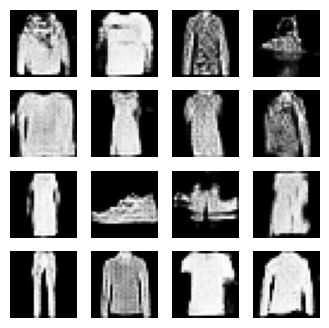

In [23]:
treinar(X_train, epochs)

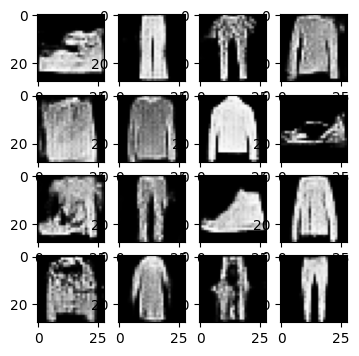

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_diretorio))
#vamos realizar um teste carregando o checkpoint
seed_input = tf.random.normal([num_amostras, noise_dim])
preds = gerador(seed_input, training = False)
fig = plt.figure(figsize=(4,4))

for i in range(preds.shape[0]):
  plt.subplot(4, 4, i+1) #4 linhas, 4 colunas e id no gráfico
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')